#HW3 - Regression

In [568]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split
from tabulate import tabulate


# Import sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

# !pip uninstall scikit-learn
# !pip install -U scikit-learn

# sklearn.__version__

# Section 1: Quick data exploration and preparation

In [569]:
##### Loading CSV from Github: #####
#set your working_dir
working_dir = os.path.join(os.getcwd(), 'covid-19')

variant_labled_csv_file_path = 'https://raw.githubusercontent.com/chenp640/ML_Major_HW1/main/variant_labeled.csv'

# Import csv file to pandas
df = pd.read_csv(variant_labled_csv_file_path, sep=',', header=0)
print ("The shape of loaded 'Variant_labeled' DataFrame is: ", end='')
df.shape

The shape of loaded 'Variant_labeled' DataFrame is: 

(4000, 34)

## Splitting the data

### (Q1)
Splitting the data into a train set and test set by 80/20.

In [570]:
#  __________________________________________________________
# | Splitting the whole DataFrame into |train_set  |test_set |
# |                             size:  |   3200    |   800   |
# |____________________________________|___________|_________|
train_set, test_set = train_test_split(df, train_size = 0.8, random_state=11)
train_set.head()

,ID,AgeGroup,BMI,BloodType,ConversatiosPerDay,DisciplineScore,HappinessScore,HouseholdExpenseOnPresents,HouseholdExpenseOnSocialGames,HouseholdExpenseParkingTicketsPerYear,MedicalCarePerYear,NrCousins,PCR_10,PCR_17,PCR_19,PCR_32,PCR_45,PCR_46,PCR_7,PCR_72,PCR_76,PCR_8,PCR_83,PCR_89,PCR_9,PCR_93,PCR_95,Sex,SocialActivitiesPerDay,SocialMediaPerDay,SportsPerDay,StepsPerYear,StudingPerDay,VariantScore
1173,158,5.0,16.04,O+,10.0,5.0,4.0,767.42,272.51,1009.33,24.0,5.0,0.871713,-0.926689,0.775699,-0.907360,1.740726,1.208933,-0.927472,0.961847,1.988623,-1.219115,1.670132,0.607091,1.244748,0.506346,2.721963,M,62.25,15.89,NaN,5.0,10.1,0.400941
2611,10288,6.0,17.76,AB-,16.0,10.0,7.0,1665.10,118.93,418.77,52.0,6.0,1.213628,1.127280,-2.398069,-0.847628,2.132507,1.169675,-0.243295,0.781032,2.994023,0.215775,2.092452,3.501812,1.477301,1.188095,1.933134,F,47.63,78.94,23.81,6.0,NaN,0.486476
806,8353,3.0,19.30,NaN,6.0,5.0,3.0,313.34,510.14,758.64,27.0,3.0,0.495729,-1.358031,1.876502,0.730574,-2.750321,-1.080803,-0.636993,-0.575737,-4.627786,-1.248662,NaN,-1.452406,-0.411393,-2.312345,2.204755,M,86.53,119.93,43.27,3.0,7.7,0.478504
1533,5958,6.0,15.14,NaN,14.0,NaN,6.0,NaN,580.55,227.36,34.0,6.0,2.822455,-0.974027,0.174849,0.366057,-1.307581,-0.535928,-0.337134,4.141643,-2.160617,-3.329401,-1.310052,0.703816,5.846958,-1.059084,6.470677,F,94.18,26.81,47.09,6.0,2.2,0.471858
1000,9753,5.0,19.06,O+,13.0,6.0,6.0,1274.53,498.55,627.96,30.0,5.0,0.935188,1.098444,-2.696669,0.247230,-1.033631,-0.373945,0.487853,-1.241913,-1.796993,NaN,-1.042995,0.562345,-0.224168,-0.927832,1.444222,M,85.13,126.48,42.56,5.0,6.2,0.670306


## Before preprocessing

### (Q2)

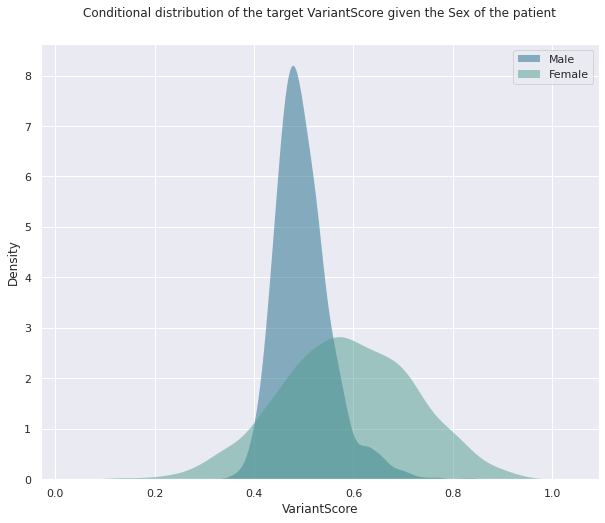

In [571]:
sns.set_theme()
f, axs = plt.subplots(1, 1, figsize=(10, 8))
f = sns.kdeplot(data=train_set, x="VariantScore", hue="Sex", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)
f.set_title('Conditional distribution of the target VariantScore given the Sex of the patient', y=1.05)
_ = f.legend(labels=["Male","Female"])

### (Q3)

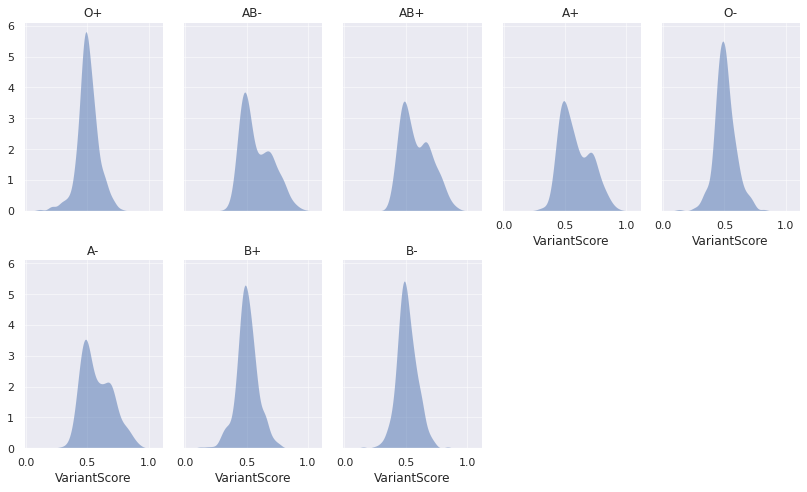

In [572]:
g = sns.FacetGrid(train_set, col="BloodType", height=3.5, aspect=.65, col_wrap=5)
g.map(sns.kdeplot, "VariantScore", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)
g.set_titles(col_template="{col_name}", size=12)
g.set_xlabels(size=12)
for ax in g.axes:
  ax.grid(alpha=0.5)

## Preprocessing (data preparation)

In [573]:
train_set_column_names = train_set.columns

print("Num of missing values (NaN) for each feature on Train Set:", end='\n\n')
for i in range (len(train_set_column_names)):
  print(train_set_column_names[i], "     ", train_set[train_set_column_names[i]].isnull().sum())

Num of missing values (NaN) for each feature on Train Set:

ID       0
AgeGroup       285
BMI       331
BloodType       328
ConversatiosPerDay       318
DisciplineScore       315
HappinessScore       352
HouseholdExpenseOnPresents       306
HouseholdExpenseOnSocialGames       321
HouseholdExpenseParkingTicketsPerYear       279
MedicalCarePerYear       289
NrCousins       285
PCR_10       335
PCR_17       310
PCR_19       346
PCR_32       314
PCR_45       305
PCR_46       313
PCR_7       318
PCR_72       306
PCR_76       314
PCR_8       314
PCR_83       319
PCR_89       336
PCR_9       303
PCR_93       333
PCR_95       300
Sex       0
SocialActivitiesPerDay       325
SocialMediaPerDay       297
SportsPerDay       304
StepsPerYear       285
StudingPerDay       355
VariantScore       0


In [574]:
# Fill missing values by distribution of non-missing values for all the features
def fillMissingValues(data_set, column_names):
  for i in range (len(column_names)):
    d = data_set[column_names[i]].value_counts(normalize=True)
    missing = data_set[column_names[i]].isna()
    data_set.loc[missing, column_names[i]] = np.random.choice(d.index, size=len(data_set[missing]),p=d.values)

fillMissingValues(train_set, train_set_column_names)
fillMissingValues(test_set, train_set_column_names)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [575]:
print("Num of missing values (NaN) for each feature on Train Set after filling missing values:", end='\n\n')
for i in range (len(train_set_column_names)):
  print(train_set_column_names[i], "     ", train_set[train_set_column_names[i]].isnull().sum())

Num of missing values (NaN) for each feature on Train Set after filling missing values:

ID       0
AgeGroup       0
BMI       0
BloodType       0
ConversatiosPerDay       0
DisciplineScore       0
HappinessScore       0
HouseholdExpenseOnPresents       0
HouseholdExpenseOnSocialGames       0
HouseholdExpenseParkingTicketsPerYear       0
MedicalCarePerYear       0
NrCousins       0
PCR_10       0
PCR_17       0
PCR_19       0
PCR_32       0
PCR_45       0
PCR_46       0
PCR_7       0
PCR_72       0
PCR_76       0
PCR_8       0
PCR_83       0
PCR_89       0
PCR_9       0
PCR_93       0
PCR_95       0
Sex       0
SocialActivitiesPerDay       0
SocialMediaPerDay       0
SportsPerDay       0
StepsPerYear       0
StudingPerDay       0
VariantScore       0


In [576]:
VariantScore_loc = train_set.columns.get_loc('VariantScore')
X_train, Y_train = train_set.iloc[:, 0 : VariantScore_loc], train_set.iloc[:, VariantScore_loc:]
X_train_column_names = X_train.columns

X_test, Y_test = test_set.iloc[:, 0 : VariantScore_loc], test_set.iloc[:, VariantScore_loc:]
X_test_column_names = X_train_column_names

In [577]:
# Transform BloodType from Category to Numeric
def BloodTypeConvert(x):    # Convert BloodType from 'Regular format' to numeric identifier
  blood_types = {'AB+' : 0, 'AB-' : 0, 'A+' : 0, 'A-' : 0, 'B+' : 1, 'B-' : 1, 'O+' : 1, 'O-' : 1}
  return blood_types[x]

X_train['BloodType'] = [BloodTypeConvert(x) for x in X_train['BloodType'].to_list()]
X_test['BloodType'] = [BloodTypeConvert(x) for x in X_test['BloodType'].to_list()]

# Transform Sex from Category to Numeric ('0' for Male, '1' for Female)
X_train['Sex'] = [0 if x == 'M' else 1 for x in X_train['Sex'].to_list()]
X_test['Sex'] = [0 if x == 'M' else 1 for x in X_test['Sex'].to_list()]

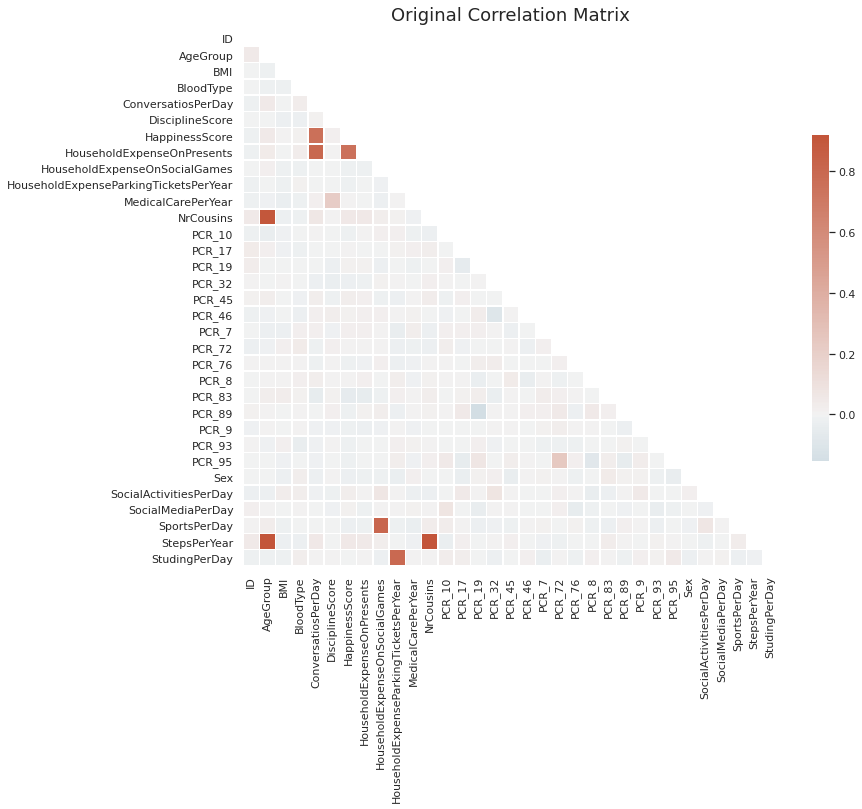

In [578]:
def printCorrelationMatrix(title):
  sns.set_theme(style="white")

  # Compute the correlation matrix
  corr = X_train.corr()

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(12, 12))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

  _ = plt.title(title, fontsize=18, pad=10)

printCorrelationMatrix('Original Correlation Matrix')

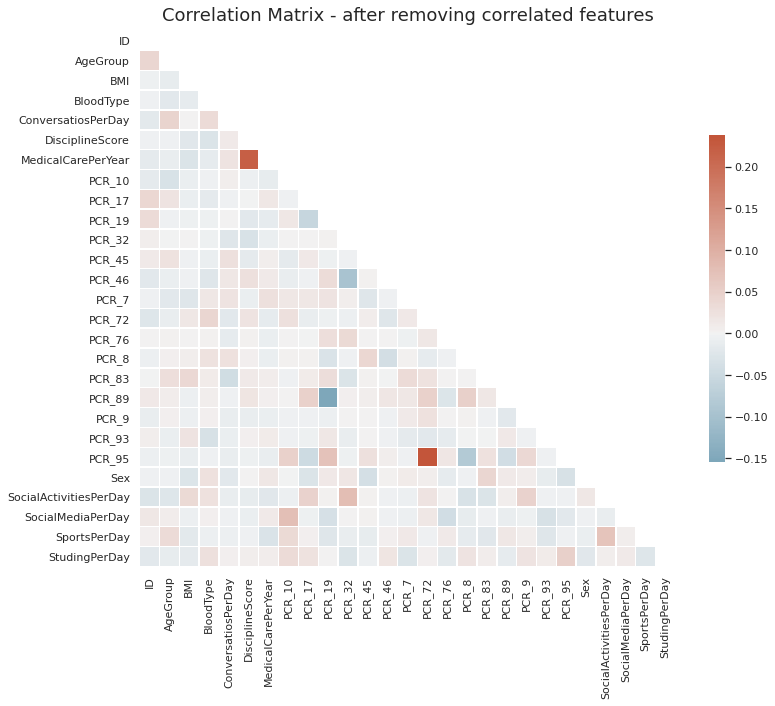

In [579]:
#Dropping the correlated features
X_train = X_train.drop(columns=['HappinessScore', 'HouseholdExpenseOnPresents', 'NrCousins', 'HouseholdExpenseOnSocialGames', 'StepsPerYear', 'HouseholdExpenseParkingTicketsPerYear'])
X_test = X_test.drop(columns=['HappinessScore', 'HouseholdExpenseOnPresents', 'NrCousins', 'HouseholdExpenseOnSocialGames', 'StepsPerYear', 'HouseholdExpenseParkingTicketsPerYear'])

printCorrelationMatrix('Correlation Matrix - after removing correlated features')

In [580]:
# Normalization:
def norm(dataset):
  for col in dataset.columns:
    if col != 'Sex' and col != 'ID':
      dataset[col] = stats.zscore(dataset[col])

norm(X_train)
norm(X_test)

train_set_sex_column_backup = train_set['Sex']
train_set = pd.concat([X_train, Y_train], axis=1) # Update the train_set
train_set['Sex'] = train_set_sex_column_backup

### (Q4) + (Q5) + (Q6) - in the report PDF

# Section 2: Evaluation

### (Q7)

In [581]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

def CV_evaluation(h, X_train, Y_train, n_splits=5):
  scores = cross_validate(h, X_train, Y_train, cv=n_splits, scoring=make_scorer(mean_squared_error), return_train_score=True)
  train_mse = scores['train_score'].mean() # a DummyRegressor that always predicts the average VariantScore of the train set
  valid_mse = scores['test_score'].mean()
  return (train_mse, valid_mse)


dummy_regr = DummyRegressor(strategy="mean")
train_mse, valid_mse = CV_evaluation(dummy_regr, X_train, Y_train)

table_printing_headers = ['Model', 'Section', 'Train MSE', 'Valid MSE', 'Best hyperparameter']
table_printing_values = [['Dummy', '2', train_mse, valid_mse, '-']]

print(tabulate(table_printing_values, headers=table_printing_headers))

Model      Section    Train MSE    Valid MSE  Best hyperparameter
-------  ---------  -----------  -----------  ---------------------
Dummy            2    0.0125773    0.0125841  -


In [582]:
# Retrain the dummy regressor on the entire train set and save it for future use (Section 6)
dummy_regressor_fitted_entire_train_set = dummy_regr.fit(X_train, Y_train)

# Section 3: Basic linear regression

### (Q8)

In [583]:
from sklearn.linear_model import Ridge

ridge_num_of_values = 200
valid_mse_dummy = [valid_mse] * ridge_num_of_values
regularization_strength_values = np.logspace(-5, 5, num=ridge_num_of_values)

def ridgeStrengthSweep(X_train, Y_train, regularization_strength_values):
  train_mse_ridge, valid_mse_ridge = [], []

  for x in regularization_strength_values:
    ridge_regr = Ridge(alpha=x, fit_intercept=True)
    train_mse, valid_mse = CV_evaluation(ridge_regr, X_train, Y_train)
    train_mse_ridge.append(train_mse)
    valid_mse_ridge.append(valid_mse)
  return train_mse_ridge, valid_mse_ridge

In [584]:
train_mse_ridge, valid_mse_ridge = ridgeStrengthSweep(X_train, Y_train, regularization_strength_values)

In [585]:
from matplotlib.pyplot import semilogx

def plotSemilogx(x_values, y_values):
  sns.set_theme()
  f, axs = plt.subplots(1, 1, figsize=(10, 8))
  for y in y_values:
    f = semilogx(x_values, y)
  f = axs.legend(['Train MSE Ridge', 'Validation MSE Ridge', 'Validation MSE Dummy'])
  f = axs.set_xlabel('Regularization strength')
  f = axs.set_ylabel('Error')
  f = axs.set_title('MSE of VariantScore', y=1.05)

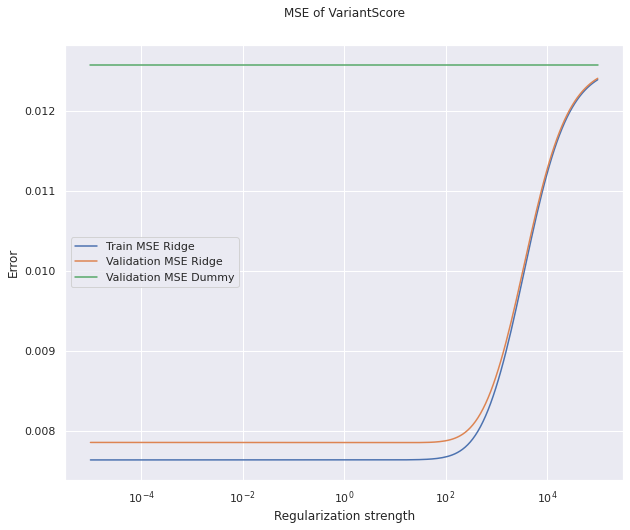

In [586]:
plotSemilogx(regularization_strength_values, [train_mse_ridge, valid_mse_ridge, valid_mse_dummy])

### (Q9)

In [587]:
valid_mse_ridge_best_performing_alpha_hyperparameter = regularization_strength_values[valid_mse_ridge.index(min(valid_mse_ridge))]

ridge_regr = Ridge(alpha=valid_mse_ridge_best_performing_alpha_hyperparameter, fit_intercept=True)
train_mse, valid_mse = CV_evaluation(ridge_regr, X_train, Y_train)

table_printing_values.append(['Basic linear', '3', train_mse, valid_mse, valid_mse_ridge_best_performing_alpha_hyperparameter])
print(tabulate(table_printing_values, headers=table_printing_headers))

Model           Section    Train MSE    Valid MSE  Best hyperparameter
------------  ---------  -----------  -----------  ---------------------
Dummy                 2   0.0125773    0.0125841   -
Basic linear          3   0.00763784   0.00785328  19.116440753857038


In [588]:
# Save the model for Section 8
ridge_regr_3 = ridge_regr

# Retrain the Ridge (basic linear) regressor on the entire train set and save it for future use (Section 6)
ridge_regressor_fitted_entire_train_set = ridge_regr.fit(X_train, Y_train)

### (Q10)

In [589]:
feature_coefficients = abs(ridge_regressor_fitted_entire_train_set.coef_[0])
feature_coefficients = pd.DataFrame({'feature' : X_train.columns.to_list(), 'coefficients' : feature_coefficients})

feature_coefficients.sort_values(by='coefficients', ascending=False, inplace=True)

print(feature_coefficients.head(5))

      feature  coefficients
22        Sex      0.082362
14     PCR_72      0.037779
3   BloodType      0.031607
13      PCR_7      0.015825
9      PCR_19      0.015396


# Section 4: Hierarchical linear regression

### (Q11)

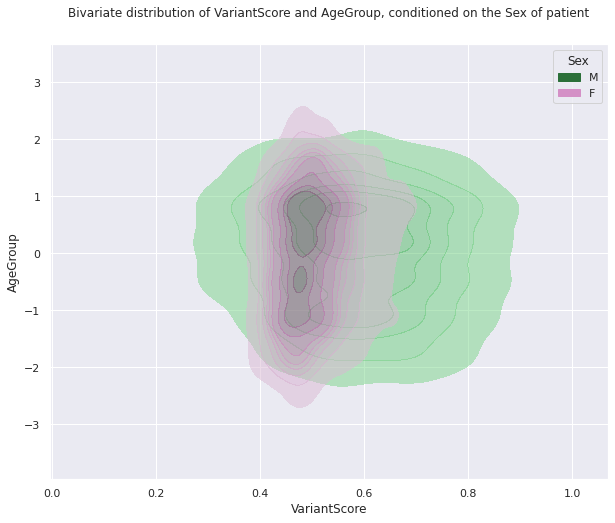

In [590]:
sns.set_theme()
f, axs = plt.subplots(1, 1, figsize=(10, 8))
f = sns.kdeplot(data=train_set, x="VariantScore", y="AgeGroup", hue='Sex', fill=True, palette="cubehelix", alpha=.5)
_ = f.set_title('Bivariate distribution of VariantScore and AgeGroup, conditioned on the Sex of patient', y=1.05)

Splitting the training set into two subsets - female patients and male patients

In [591]:
train_set_male = train_set[train_set['Sex'] == 'M'].copy()
train_set_female = train_set[train_set['Sex'] == 'F'].copy()

train_set_male.drop(columns=['Sex'], inplace=True)
train_set_female.drop(columns=['Sex'], inplace=True)

X_train_male, Y_train_male = train_set_male.iloc[:, 0 : train_set_male.columns.get_loc('VariantScore')], train_set_male.iloc[:, train_set_male.columns.get_loc('VariantScore'):]
X_train_female, Y_train_female = train_set_female.iloc[:, 0 : train_set_female.columns.get_loc('VariantScore')], train_set_female.iloc[:, train_set_female.columns.get_loc('VariantScore'):]

### (Q12)

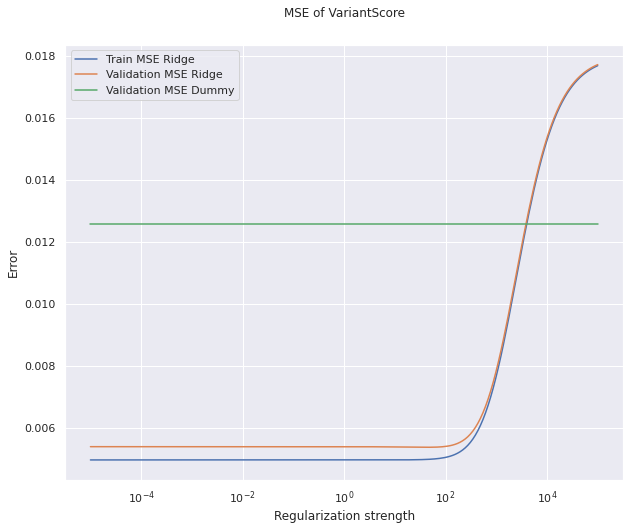

In [592]:
# regularization strength of a Ridge regressor - Male
train_mse_male, valid_mse_male = ridgeStrengthSweep(X_train_male, Y_train_male, regularization_strength_values)
plotSemilogx(regularization_strength_values, [train_mse_male, valid_mse_male, valid_mse_dummy])

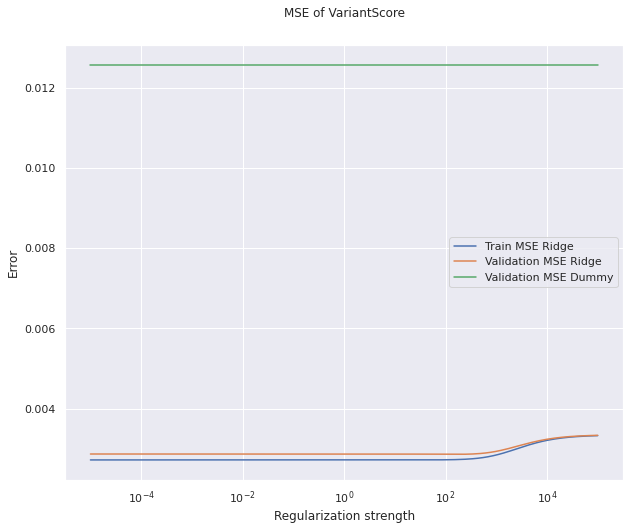

In [593]:
# regularization strength of a Ridge regressor - Female
train_mse_female, valid_mse_female = ridgeStrengthSweep(X_train_female, Y_train_female, regularization_strength_values)
plotSemilogx(regularization_strength_values, [train_mse_female, valid_mse_female, valid_mse_dummy])

In [594]:
# Running the Ridge regressor with the best hyperparameter for Male
valid_mse_male_ridge_best_performing_alpha_hyperparameter = regularization_strength_values[valid_mse_male.index(min(valid_mse_male))]
ridge_regr = Ridge(alpha=valid_mse_male_ridge_best_performing_alpha_hyperparameter, fit_intercept=True)
train_mse_male, valid_mse_male = CV_evaluation(ridge_regr, X_train_male, Y_train_male)

# Running the Ridge regressor with the best hyperparameter for Female
valid_mse_female_ridge_best_performing_alpha_hyperparameter = regularization_strength_values[valid_mse_female.index(min(valid_mse_female))]
ridge_regr = Ridge(alpha=valid_mse_female_ridge_best_performing_alpha_hyperparameter, fit_intercept=True)
train_mse_female, valid_mse_female = CV_evaluation(ridge_regr, X_train_female, Y_train_female)

In [595]:
print(tabulate([['Male', valid_mse_male_ridge_best_performing_alpha_hyperparameter, valid_mse_male],
                ['Female', valid_mse_female_ridge_best_performing_alpha_hyperparameter, valid_mse_female]], headers=['Subset', 'Optimal Strength', 'Optimal Validation MSE']))

Subset      Optimal Strength    Optimal Validation MSE
--------  ------------------  ------------------------
Male                  42.97                 0.00538517
Female               153.437                0.00285692


In [596]:
from sklearn.base import BaseEstimator, RegressorMixin

# In 'Sex' column, 0 is for Male and 1 is for Female
class MultiRegressor(BaseEstimator, RegressorMixin):
  def __init__(self, h_male, h_female):
    self.h_male = h_male
    self.h_female = h_female

  def fit(self, X, y):
    X_m = X[X['Sex'] == 0]
    X_m = X_m.drop('Sex', axis='columns')

    X_f = X[X['Sex'] == 1]
    X_f = X_f.drop('Sex', axis='columns')

    self.h_male.fit(X_m, y[X['Sex'] == 0])
    self.h_female.fit(X_f, y[X['Sex'] == 1])
    return self

  def predict(self, X):
    # X should be a pandas dataframe
    all_predictions = []
    for index, x in X.iterrows():
      x_without_sex = x.drop('Sex')
      y_pred = self.h_male.predict([x_without_sex]) if x['Sex'] == 0 else self.h_female.predict([x_without_sex])
      all_predictions.append(y_pred[0][0])

    return all_predictions

### (Q13)

In [597]:
h_combined = MultiRegressor(Ridge(alpha=valid_mse_male_ridge_best_performing_alpha_hyperparameter, fit_intercept=True), Ridge(alpha=valid_mse_female_ridge_best_performing_alpha_hyperparameter, fit_intercept=True))
train_mse_combined, valid_mse_combined = CV_evaluation(h_combined, X_train, Y_train)

string_of_best_hyperparameters = 'Male: ' + str(valid_mse_male_ridge_best_performing_alpha_hyperparameter) + ', Female: ' + str(valid_mse_female_ridge_best_performing_alpha_hyperparameter)
table_printing_values.append(['Multilevel linear', '4', train_mse_combined, valid_mse_combined, string_of_best_hyperparameters])
print(tabulate(table_printing_values, headers=table_printing_headers))

Model                Section    Train MSE    Valid MSE  Best hyperparameter
-----------------  ---------  -----------  -----------  ---------------------------------------------------
Dummy                      2   0.0125773    0.0125841   -
Basic linear               3   0.00763784   0.00785328  19.116440753857038
Multilevel linear          4   0.00385955   0.00411674  Male: 42.97004704320844, Female: 153.43684089300132


### (Q14) - in the report PDF

In [598]:
# Save the model for Section 8
h_combined_4 = h_combined

# Retrain the Multilevel regressor on the entire train set and save it for future use (Section 6)
multilevel_regressor_fitted_entire_train_set = h_combined.fit(X_train, Y_train)

# Section 5: Polynomial fitting

In [599]:
X_train_quadratic = X_train.copy()
X_test_quadratic = X_test.copy()

col_names = X_train_quadratic.columns

for col in col_names:
  if col != 'Sex' and col != 'ID':
    corresponding_quadratic_col_name = col + '_quad'
    X_train_quadratic[corresponding_quadratic_col_name] = [(x * x) for x in X_train_quadratic[col]]
    X_test_quadratic[corresponding_quadratic_col_name] = [(x * x) for x in X_test_quadratic[col]]

print('Original X_train:', end='\n\n')
X_train.head()

Original X_train:



,ID,AgeGroup,BMI,BloodType,ConversatiosPerDay,DisciplineScore,MedicalCarePerYear,PCR_10,PCR_17,PCR_19,PCR_32,PCR_45,PCR_46,PCR_7,PCR_72,PCR_76,PCR_8,PCR_83,PCR_89,PCR_9,PCR_93,PCR_95,Sex,SocialActivitiesPerDay,SocialMediaPerDay,SportsPerDay,StudingPerDay
1173,158,0.175139,-0.285733,0.995635,-0.749639,-0.167884,-0.261039,-0.073284,-0.048650,0.562229,0.016817,0.039025,-0.034321,-1.499961,0.337446,0.026382,0.043984,-0.013908,-0.274203,-0.062845,-0.013466,0.224387,0,-0.160890,-0.233027,-0.664543,1.181022
2611,10288,0.828339,-0.204688,-1.004385,0.933564,0.786002,3.566339,-0.070544,-0.028977,-1.201693,0.017293,0.041359,-0.034654,-0.383686,0.181145,0.031503,0.053339,-0.010871,0.606906,-0.061167,-0.007706,-0.118236,1,-0.222302,-0.148672,-1.446479,0.979449
806,8353,-1.131260,-0.132125,-1.004385,-1.871775,-0.167884,0.149037,-0.076298,-0.052781,1.174036,0.029868,0.012270,-0.053717,-1.026028,-0.991680,-0.007313,0.043791,-0.048546,-0.901083,-0.074802,-0.037281,-0.000259,0,-0.058900,-0.093832,0.574302,0.489913
1533,5958,0.828339,-0.328140,-1.004385,0.372496,-0.167884,1.105882,-0.057652,-0.049103,0.228288,0.026963,0.020865,-0.049101,-0.536791,3.086139,0.005252,0.030224,-0.035336,-0.244762,-0.029621,-0.026692,1.852619,1,-0.026766,-0.218417,0.970981,-1.093878
1000,9753,0.175139,-0.143433,0.995635,0.091963,0.022893,0.559113,-0.072776,-0.029253,-1.367649,0.026017,0.022497,-0.047729,0.809225,-1.567539,0.007104,0.062852,-0.033416,-0.287823,-0.073450,-0.025583,-0.330592,0,-0.064781,-0.085069,0.500574,0.057970


In [600]:
print('X_train with the quadratic features:', end='\n\n')
X_train_quadratic.head()

X_train with the quadratic features:



,ID,AgeGroup,BMI,BloodType,ConversatiosPerDay,DisciplineScore,MedicalCarePerYear,PCR_10,PCR_17,PCR_19,PCR_32,PCR_45,PCR_46,PCR_7,PCR_72,PCR_76,PCR_8,PCR_83,PCR_89,PCR_9,PCR_93,PCR_95,Sex,SocialActivitiesPerDay,SocialMediaPerDay,SportsPerDay,StudingPerDay,AgeGroup_quad,BMI_quad,BloodType_quad,ConversatiosPerDay_quad,DisciplineScore_quad,MedicalCarePerYear_quad,PCR_10_quad,PCR_17_quad,PCR_19_quad,PCR_32_quad,PCR_45_quad,PCR_46_quad,PCR_7_quad,PCR_72_quad,PCR_76_quad,PCR_8_quad,PCR_83_quad,PCR_89_quad,PCR_9_quad,PCR_93_quad,PCR_95_quad,SocialActivitiesPerDay_quad,SocialMediaPerDay_quad,SportsPerDay_quad,StudingPerDay_quad
1173,158,0.175139,-0.285733,0.995635,-0.749639,-0.167884,-0.261039,-0.073284,-0.048650,0.562229,0.016817,0.039025,-0.034321,-1.499961,0.337446,0.026382,0.043984,-0.013908,-0.274203,-0.062845,-0.013466,0.224387,0,-0.160890,-0.233027,-0.664543,1.181022,0.030674,0.081643,0.991288,0.561959,0.028185,0.068141,0.005371,0.002367,0.316102,0.000283,0.001523,0.001178,2.249884,0.113870,0.000696,0.001935,0.000193,0.075187,0.003950,0.000181,5.034970e-02,0.025886,0.054302,0.441617,1.394814
2611,10288,0.828339,-0.204688,-1.004385,0.933564,0.786002,3.566339,-0.070544,-0.028977,-1.201693,0.017293,0.041359,-0.034654,-0.383686,0.181145,0.031503,0.053339,-0.010871,0.606906,-0.061167,-0.007706,-0.118236,1,-0.222302,-0.148672,-1.446479,0.979449,0.686145,0.041897,1.008788,0.871542,0.617799,12.718774,0.004977,0.000840,1.444066,0.000299,0.001711,0.001201,0.147215,0.032814,0.000992,0.002845,0.000118,0.368335,0.003741,0.000059,1.397965e-02,0.049418,0.022103,2.092301,0.959320
806,8353,-1.131260,-0.132125,-1.004385,-1.871775,-0.167884,0.149037,-0.076298,-0.052781,1.174036,0.029868,0.012270,-0.053717,-1.026028,-0.991680,-0.007313,0.043791,-0.048546,-0.901083,-0.074802,-0.037281,-0.000259,0,-0.058900,-0.093832,0.574302,0.489913,1.279749,0.017457,1.008788,3.503540,0.028185,0.022212,0.005821,0.002786,1.378360,0.000892,0.000151,0.002885,1.052733,0.983428,0.000053,0.001918,0.002357,0.811951,0.005595,0.001390,6.691046e-08,0.003469,0.008804,0.329823,0.240015
1533,5958,0.828339,-0.328140,-1.004385,0.372496,-0.167884,1.105882,-0.057652,-0.049103,0.228288,0.026963,0.020865,-0.049101,-0.536791,3.086139,0.005252,0.030224,-0.035336,-0.244762,-0.029621,-0.026692,1.852619,1,-0.026766,-0.218417,0.970981,-1.093878,0.686145,0.107676,1.008788,0.138754,0.028185,1.222974,0.003324,0.002411,0.052115,0.000727,0.000435,0.002411,0.288144,9.524254,0.000028,0.000914,0.001249,0.059908,0.000877,0.000712,3.432196e+00,0.000716,0.047706,0.942805,1.196569
1000,9753,0.175139,-0.143433,0.995635,0.091963,0.022893,0.559113,-0.072776,-0.029253,-1.367649,0.026017,0.022497,-0.047729,0.809225,-1.567539,0.007104,0.062852,-0.033416,-0.287823,-0.073450,-0.025583,-0.330592,0,-0.064781,-0.085069,0.500574,0.057970,0.030674,0.020573,0.991288,0.008457,0.000524,0.312608,0.005296,0.000856,1.870464,0.000677,0.000506,0.002278,0.654845,2.457177,0.000050,0.003950,0.001117,0.082842,0.005395,0.000654,1.092908e-01,0.004197,0.007237,0.250574,0.003361


### (Q15) + (Q16) - in the report PDF

### (Q17)

In [601]:
# In 'Sex' column, 0 is for Male and 1 is for Female
X_train_quadratic_male = X_train_quadratic[X_train_quadratic['Sex'] == 0].copy()
Y_train_quadratic_male = Y_train_male.copy()

X_train_quadratic_female = X_train_quadratic[X_train_quadratic['Sex'] == 1].copy()
Y_train_quadratic_female = Y_train_female.copy()

X_train_quadratic_male.drop(columns=['Sex'], inplace=True)
X_train_quadratic_female.drop(columns=['Sex'], inplace=True)

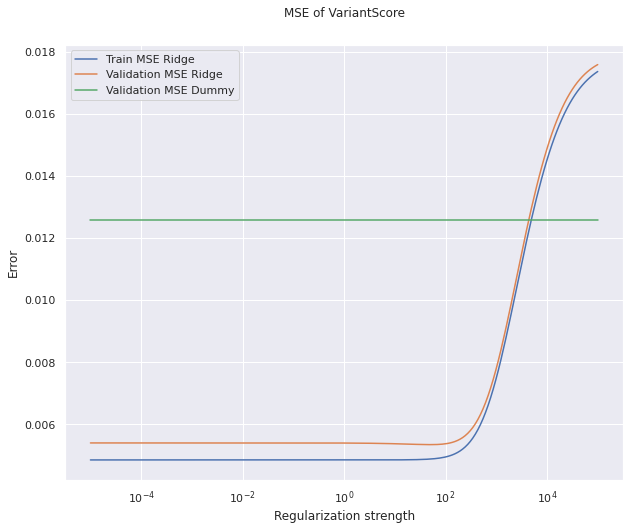

In [602]:
# regularization strength of a Ridge regressor - Male
train_quadratic_mse_male, valid_quadratic_mse_male = ridgeStrengthSweep(X_train_quadratic_male, Y_train_quadratic_male, regularization_strength_values)
plotSemilogx(regularization_strength_values, [train_quadratic_mse_male, valid_quadratic_mse_male, valid_mse_dummy])

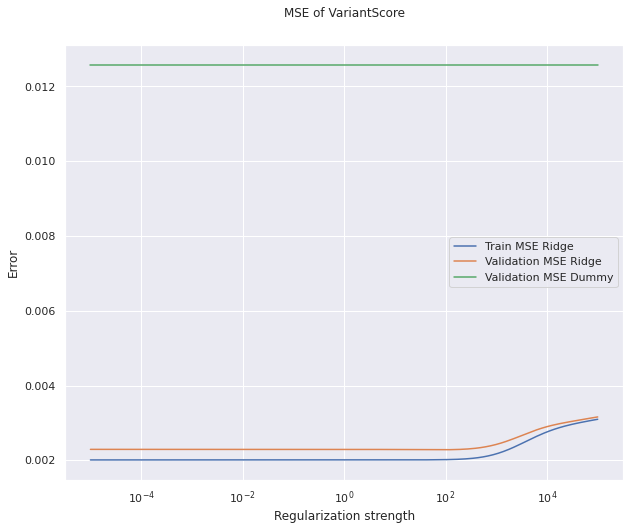

In [603]:
# regularization strength of a Ridge regressor - Female
train_quadratic_mse_female, valid_quadratic_mse_female = ridgeStrengthSweep(X_train_quadratic_female, Y_train_quadratic_female, regularization_strength_values)
plotSemilogx(regularization_strength_values, [train_quadratic_mse_female, valid_quadratic_mse_female, valid_mse_dummy])

In [604]:
# Running the Multilevel Polynomial regressor with the best hyperparameter for Male
valid_quadratic_mse_male_ridge_best_performing_alpha_hyperparameter = regularization_strength_values[valid_quadratic_mse_male.index(min(valid_quadratic_mse_male))]
ridge_regr = Ridge(alpha=valid_quadratic_mse_male_ridge_best_performing_alpha_hyperparameter, fit_intercept=True)
train_quadratic_mse_male, valid_quadratic_mse_male = CV_evaluation(ridge_regr, X_train_quadratic_male, Y_train_quadratic_male)

# Running the Multilevel Polynomial regressor with the best hyperparameter for Female
valid_quadratic_mse_female_ridge_best_performing_alpha_hyperparameter = regularization_strength_values[valid_quadratic_mse_female.index(min(valid_quadratic_mse_female))]
ridge_regr = Ridge(alpha=valid_quadratic_mse_female_ridge_best_performing_alpha_hyperparameter, fit_intercept=True)
train_quadratic_mse_female, valid_quadratic_mse_female = CV_evaluation(ridge_regr, X_train_quadratic_female, Y_train_quadratic_female)

In [605]:
print(tabulate([['Male', valid_quadratic_mse_male_ridge_best_performing_alpha_hyperparameter, valid_quadratic_mse_male],
                ['Female', valid_quadratic_mse_female_ridge_best_performing_alpha_hyperparameter, valid_quadratic_mse_female]], headers=['Subset', 'Optimal Strength', 'Optimal Validation MSE']))

Subset      Optimal Strength    Optimal Validation MSE
--------  ------------------  ------------------------
Male                 48.2411                0.00534881
Female               68.2607                0.00228318


### (Q18)

In [606]:
table_printing_values_18 = []
table_printing_values_18.append(['Linear', '4', 'M', train_mse_male, valid_mse_male])
table_printing_values_18.append(['Polynomial', '5', 'M', train_quadratic_mse_male, valid_quadratic_mse_male])
table_printing_values_18.append(['Linear', '4', 'F', train_mse_female, valid_mse_female])
table_printing_values_18.append(['Polynomial', '5', 'F', train_quadratic_mse_female, valid_quadratic_mse_female])

print(tabulate(table_printing_values_18, headers=['Multilevel Model', 'Section', 'Sex', 'Train MSE', 'Valid MSE'], tablefmt='github'))

| Multilevel Model   |   Section | Sex   |   Train MSE |   Valid MSE |
|--------------------|-----------|-------|-------------|-------------|
| Linear             |         4 | M     |  0.0049936  |  0.00538517 |
| Polynomial         |         5 | M     |  0.00488226 |  0.00534881 |
| Linear             |         4 | F     |  0.00272449 |  0.00285692 |
| Polynomial         |         5 | F     |  0.00201593 |  0.00228318 |


### (Q19) - in the report PDF

### (Q20)

In [607]:
h_combined = MultiRegressor(Ridge(alpha=valid_quadratic_mse_male_ridge_best_performing_alpha_hyperparameter, fit_intercept=True), Ridge(alpha=valid_quadratic_mse_female_ridge_best_performing_alpha_hyperparameter, fit_intercept=True))
train_quadratic_mse_combined, valid_quadratic_mse_combined = CV_evaluation(h_combined, X_train_quadratic, Y_train)

string_of_best_hyperparameters = 'Male: ' + str(valid_quadratic_mse_male_ridge_best_performing_alpha_hyperparameter) + ', Female: ' + str(valid_quadratic_mse_female_ridge_best_performing_alpha_hyperparameter)
table_printing_values.append(['Multilevel polynomial', '5', train_quadratic_mse_combined, valid_quadratic_mse_combined, string_of_best_hyperparameters])
print(tabulate(table_printing_values, headers=table_printing_headers))

Model                    Section    Train MSE    Valid MSE  Best hyperparameter
---------------------  ---------  -----------  -----------  ---------------------------------------------------
Dummy                          2   0.0125773    0.0125841   -
Basic linear                   3   0.00763784   0.00785328  19.116440753857038
Multilevel linear              4   0.00385955   0.00411674  Male: 42.97004704320844, Female: 153.43684089300132
Multilevel polynomial          5   0.00344995   0.00381305  Male: 48.241087041653735, Female: 68.26071834272393


In [608]:
# Save the model for Section 8
h_combined_5 = h_combined

# Retrain the Multilevel Polynomial regressor on the entire train set and save it for future use (Section 6)
multilevel_polynomial_regressor_fitted_entire_train_set = h_combined.fit(X_train_quadratic, Y_train)

# Section 6: Testing your models

### (Q21)

In [609]:
from sklearn.metrics import mean_squared_error

Y_test_predicted = dummy_regressor_fitted_entire_train_set.predict(X_test)
dummy_test_mse = mean_squared_error(Y_test, Y_test_predicted)
table_printing_values[0][4] = dummy_test_mse

Y_test_predicted = ridge_regressor_fitted_entire_train_set.predict(X_test)
ridge_test_mse = mean_squared_error(Y_test, Y_test_predicted)
table_printing_values[1][4] = ridge_test_mse

Y_test_predicted = multilevel_regressor_fitted_entire_train_set.predict(X_test)
multilevel_linear_test_mse = mean_squared_error(Y_test, Y_test_predicted)
table_printing_values[2][4] = multilevel_linear_test_mse

Y_test_predicted = multilevel_polynomial_regressor_fitted_entire_train_set.predict(X_test_quadratic)
multilevel_polynomial_test_mse = mean_squared_error(Y_test, Y_test_predicted)
table_printing_values[3][4] = multilevel_polynomial_test_mse

table_printing_headers[4] = 'Test MSE'
print(tabulate(table_printing_values, headers=table_printing_headers))

Model                    Section    Train MSE    Valid MSE    Test MSE
---------------------  ---------  -----------  -----------  ----------
Dummy                          2   0.0125773    0.0125841   0.0115347
Basic linear                   3   0.00763784   0.00785328  0.00740465
Multilevel linear              4   0.00385955   0.00411674  0.00363375
Multilevel polynomial          5   0.00344995   0.00381305  0.00315561


### (Q22) - in the report PDF

# Section 7: Custom models challange

In [610]:
class MultiRegressor7(BaseEstimator, RegressorMixin):
  def __init__(self, h_male, h_female):
    self.h_male = h_male
    self.h_female = h_female

  def fit(self, X, y):
    X_m = X[X['Sex'] == 0]
    X_m = X_m.drop('Sex', axis='columns')

    X_f = X[X['Sex'] == 1]
    X_f = X_f.drop('Sex', axis='columns')

    self.h_male.fit(X_m, y[X['Sex'] == 0])
    self.h_female.fit(X_f, y[X['Sex'] == 1])
    return self

  def predict(self, X):
    # X should be a pandas dataframe
    all_predictions = []
    for index, x in X.iterrows():
      x_without_sex = x.drop('Sex')
      y_pred = self.h_male.predict([x_without_sex]) if x['Sex'] == 0 else self.h_female.predict([x_without_sex])
      all_predictions.append(y_pred[0])
    return all_predictions

In [611]:
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor

section_7_h_combined = MultiRegressor7(AdaBoostRegressor(random_state=0, n_estimators=1, loss='exponential'), AdaBoostRegressor(random_state=0, n_estimators=1, loss='exponential'))
section_7_train_mse_combined, section_7_valid_mse_combined = CV_evaluation(section_7_h_combined, X_train_quadratic, Y_train)

# Test prediction:
section_7_regressor_fitted_entire_train_set = section_7_h_combined.fit(X_train_quadratic, Y_train)

Y_test_predicted = section_7_regressor_fitted_entire_train_set.predict(X_test_quadratic)
section_7_test_mse = mean_squared_error(Y_test, Y_test_predicted)


section_7_table_printing_headers = ['Model', 'Section', 'Train MSE', 'Valid MSE', 'Test MSE']
section_7_table_printing_values = [['Multilevel Lasso', '7', section_7_train_mse_combined, section_7_valid_mse_combined, section_7_test_mse]]
print(tabulate(section_7_table_printing_values, headers=section_7_table_printing_headers, tablefmt='github'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

| Model            |   Section |   Train MSE |   Valid MSE |   Test MSE |
|------------------|-----------|-------------|-------------|------------|
| Multilevel Lasso |         7 |  0.00563536 |  0.00630418 | 0.00546193 |


### (Q23) - in the report PDF

# Section 8: Submitted model predictions

In [612]:
##### Loading the variant_unlabeled.csv file from Github: #####
variant_unlabeled_csv_file_path = 'https://raw.githubusercontent.com/chenp640/ML_Major_HW1/main/variant_unlabeled.csv'

# Import csv file to pandas
unlabeled_test_set = pd.read_csv(variant_unlabeled_csv_file_path, sep=',', header=0)
print ("The shape of loaded 'Variant_unlabeled' DataFrame is: ", end='')
unlabeled_test_set.shape

The shape of loaded 'Variant_unlabeled' DataFrame is: 

(2000, 33)

In [613]:
unlabeled_test_set_column_names = unlabeled_test_set.columns

print("Num of missing values (NaN) for each feature on unlabeled_test_set:", end='\n\n')
for i in range (len(unlabeled_test_set_column_names)):
  print(unlabeled_test_set_column_names[i], "     ", unlabeled_test_set[unlabeled_test_set_column_names[i]].isnull().sum())

Num of missing values (NaN) for each feature on unlabeled_test_set:

ID       0
AgeGroup       207
BMI       212
BloodType       215
ConversatiosPerDay       218
DisciplineScore       188
HappinessScore       206
HouseholdExpenseOnPresents       208
HouseholdExpenseOnSocialGames       199
HouseholdExpenseParkingTicketsPerYear       190
MedicalCarePerYear       197
NrCousins       207
PCR_10       212
PCR_17       215
PCR_19       205
PCR_32       211
PCR_45       217
PCR_46       182
PCR_7       214
PCR_72       178
PCR_76       223
PCR_8       196
PCR_83       201
PCR_89       207
PCR_9       205
PCR_93       190
PCR_95       211
Sex       0
SocialActivitiesPerDay       202
SocialMediaPerDay       204
SportsPerDay       202
StepsPerYear       207
StudingPerDay       211


In [614]:
# Fill missing values by distribution of non-missing values for all the features
fillMissingValues(unlabeled_test_set, unlabeled_test_set_column_names)

In [615]:
print("Num of missing values (NaN) for each feature on unlabeled_test_set after filling missing values:", end='\n\n')
for i in range (len(unlabeled_test_set_column_names)):
  print(unlabeled_test_set_column_names[i], "     ", unlabeled_test_set[unlabeled_test_set_column_names[i]].isnull().sum())

Num of missing values (NaN) for each feature on unlabeled_test_set after filling missing values:

ID       0
AgeGroup       0
BMI       0
BloodType       0
ConversatiosPerDay       0
DisciplineScore       0
HappinessScore       0
HouseholdExpenseOnPresents       0
HouseholdExpenseOnSocialGames       0
HouseholdExpenseParkingTicketsPerYear       0
MedicalCarePerYear       0
NrCousins       0
PCR_10       0
PCR_17       0
PCR_19       0
PCR_32       0
PCR_45       0
PCR_46       0
PCR_7       0
PCR_72       0
PCR_76       0
PCR_8       0
PCR_83       0
PCR_89       0
PCR_9       0
PCR_93       0
PCR_95       0
Sex       0
SocialActivitiesPerDay       0
SocialMediaPerDay       0
SportsPerDay       0
StepsPerYear       0
StudingPerDay       0


In [616]:
# Transform BloodType from Category to Numeric
unlabeled_test_set['BloodType'] = [BloodTypeConvert(x) for x in unlabeled_test_set['BloodType'].to_list()]

# Transform Sex from Category to Numeric ('0' for Male, '1' for Female)
unlabeled_test_set['Sex'] = [0 if x == 'M' else 1 for x in unlabeled_test_set['Sex'].to_list()]

In [617]:
#Dropping the correlated features
unlabeled_test_set = unlabeled_test_set.drop(columns=['HappinessScore', 'HouseholdExpenseOnPresents', 'NrCousins', 'HouseholdExpenseOnSocialGames', 'StepsPerYear', 'HouseholdExpenseParkingTicketsPerYear'])

In [618]:
# Normalization:
norm(unlabeled_test_set)

In [619]:
final_X_train = pd.concat([X_train, X_test])
final_X_train_quadratic = pd.concat([X_train_quadratic, X_test_quadratic])
final_Y_train = pd.concat([Y_train, Y_test])

unlabeled_test_set_ID = unlabeled_test_set['ID']

# pred_3
ridge_regr_3.fit(final_X_train, final_Y_train)
pred_3 = ridge_regr_3.predict(unlabeled_test_set)
pred_3 = [x[0] for x in pred_3]
pred_3 = pd.DataFrame({'VariantScore' : pred_3})
pred_3 = pd.concat([unlabeled_test_set_ID, pred_3], axis=1, join="inner")

# pred_4
h_combined_4.fit(final_X_train, final_Y_train)
pred_4 = h_combined_4.predict(unlabeled_test_set)
pred_4 = pd.DataFrame({'VariantScore' : pred_4})
pred_4 = pd.concat([unlabeled_test_set_ID, pred_4], axis=1, join="inner")

# pred_5
unlabeled_test_set_quadratic = unlabeled_test_set.copy()
col_names = unlabeled_test_set_quadratic.columns

for col in col_names:
  if col != 'Sex' and col != 'ID':
    corresponding_quadratic_col_name = col + '_quad'
    unlabeled_test_set_quadratic[corresponding_quadratic_col_name] = [(x * x) for x in unlabeled_test_set_quadratic[col]]

h_combined_5.fit(final_X_train_quadratic, final_Y_train)
pred_5 = h_combined_5.predict(unlabeled_test_set_quadratic)
pred_5 = pd.DataFrame({'VariantScore' : pred_5})
pred_5 = pd.concat([unlabeled_test_set_ID, pred_5], axis=1, join="inner")

In [620]:
from google.colab import files

# pred_3 csv file generate and download
pred_3_csv_filename = "pred_3.csv"
pred_3.to_csv(pred_3_csv_filename)
files.download(pred_3_csv_filename)

# pred_4 csv file generate and download
pred_4_csv_filename = "pred_4.csv"
pred_4.to_csv(pred_4_csv_filename)
files.download(pred_4_csv_filename)

# pred_5 csv file generate and download
pred_5_csv_filename = "pred_5.csv"
pred_5.to_csv(pred_5_csv_filename)
files.download(pred_5_csv_filename)

# # pred_7 csv file generate and download
# pred_7_csv_filename = "pred_7.csv"
# pred_7.to_csv(pred_7_csv_filename)
# files.download(pred_7_csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>